## ANN

当前学习率: 0.004
6:2:2顺序划分的训练集Speed (1400, 110) OD (1400, 110, 110)
6:2:2顺序划分的验证集Speed (33, 110) OD (33, 110, 110)
6:2:2顺序划分的测试集Speed (35, 110) OD (35, 110, 110)
特征处理后的训练集 shape: (1400, 110, 4) OD形状 (1400, 110, 110)
特征处理后的验证集 shape: (33, 110, 4) OD形状 (33, 110, 110)
特征处理后的测试集 shape: (35, 110, 4) OD形状 (35, 110, 110)
[[0.23]
 [0.3 ]
 [0.83]
 [0.77]
 [0.65]
 [0.56]
 [0.25]
 [0.25]
 [0.4 ]
 [0.43]
 [0.49]
 [0.79]
 [0.86]
 [0.34]
 [0.38]
 [0.23]]
归一化后的训练集 shape: torch.Size([1400, 110, 1]) OD形状 torch.Size([1400, 110, 110])
归一化后的验证集 shape: torch.Size([33, 110, 1]) OD形状 torch.Size([33, 110, 110])
归一化后的测试集 shape: torch.Size([35, 110, 1]) OD形状 torch.Size([35, 110, 110])
输入:torch.Size([32, 110, 1]),标签:torch.Size([32, 110, 110])
输入:torch.Size([3, 110, 1]),标签:torch.Size([3, 110, 110])
Test Loss: 42.1102
Test RMSE: 6.2873 Test MAE: 1.0985 Test MAPE: 0.9649
-------------------平均时间步上---------------------
[[  0  47   6   0   8   2   7  55]
 [ 47   0 222   1  12   4   7  28]
 [  7 230   0   1   5   2   6  16

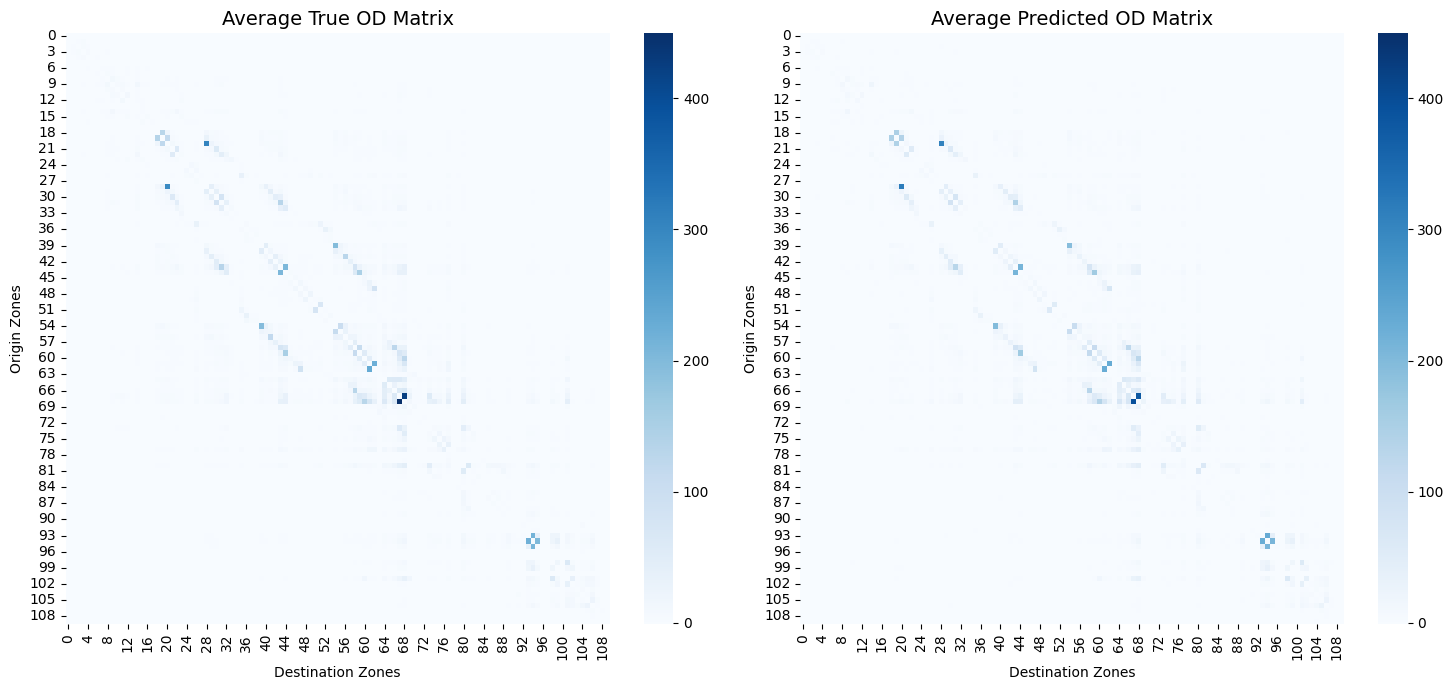

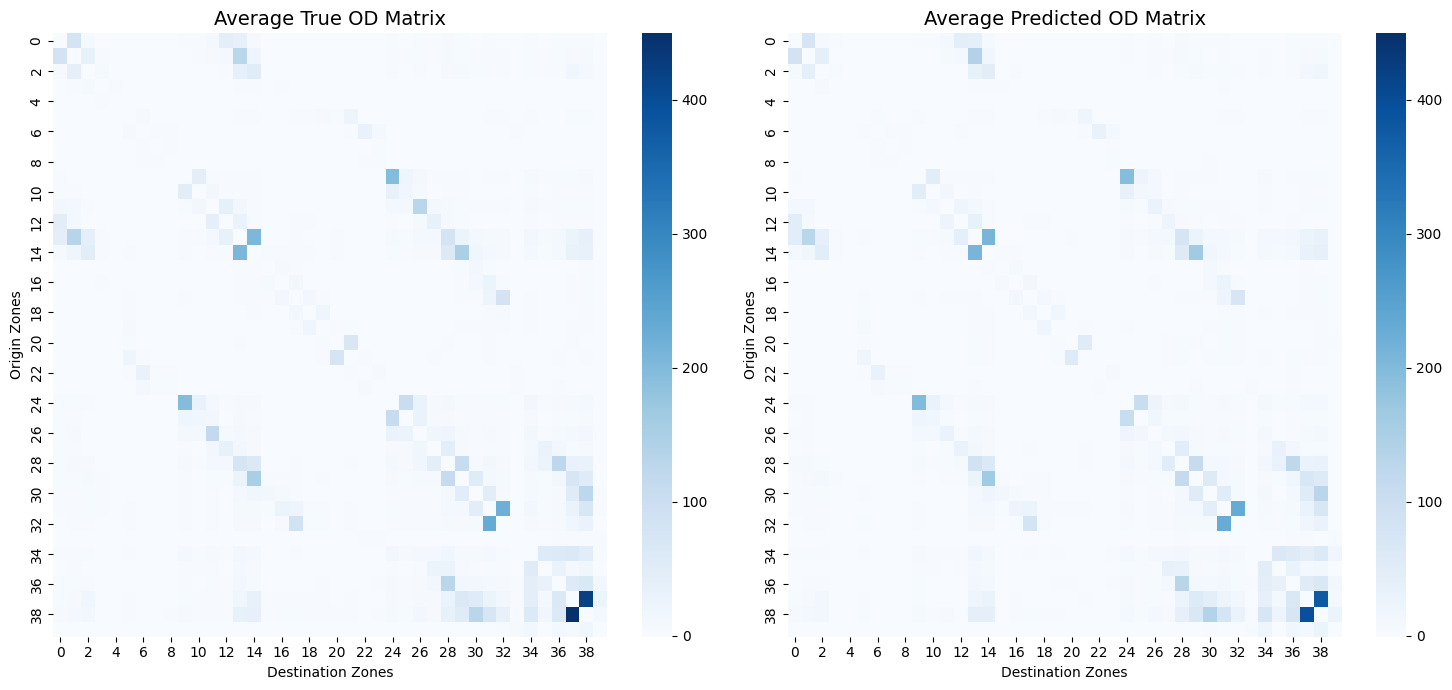

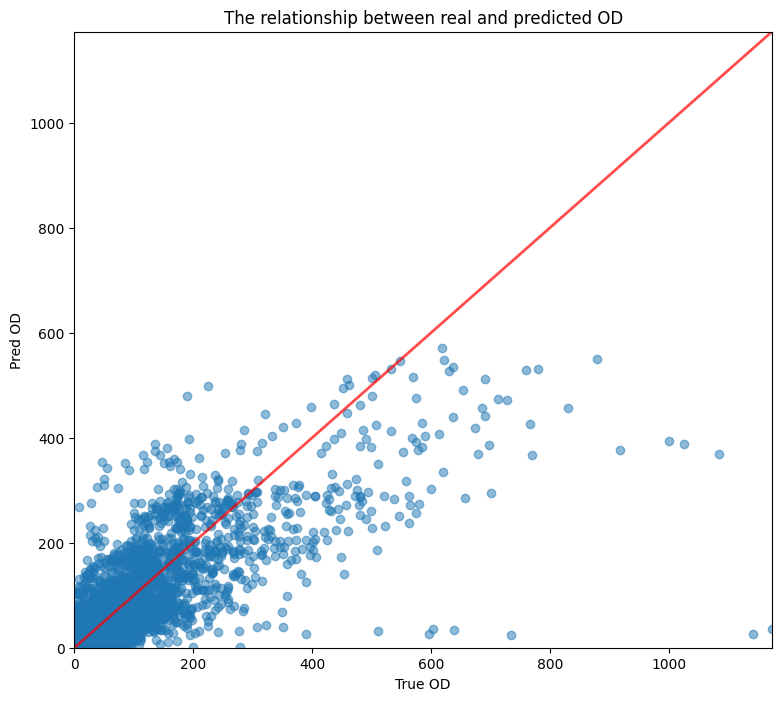

In [6]:
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
# from torchinfo import summary
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 数据准备
def normalize_data(data):
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val), min_val, max_val




# 定义模型
# 定义新模型
class ODModel(nn.Module):
    def __init__(self, N, F):
        super(ODModel, self).__init__()
        self.N = N
        self.F = F
        n1 = 128
        n2 = 64

        self.mlp = nn.Sequential(
            nn.Linear(N*F, n1),
            nn.ReLU(),
            nn.Linear(n1, n2),
            nn.ReLU(),
            nn.Linear(n2, N * N)
        )

    def forward(self, x):
        # x 的形状：[batch, N, F=1]
        batch_size, N, F = x.shape
        x = x.view(batch_size, N * F)

        # 输入到 MLP 网络中
        od_matrix_flat = self.mlp(x)  # [batch, N * N]
        # reshape为OD矩阵的形状
        od_matrix = od_matrix_flat.view(batch_size, N, N)  # [batch, N, N]

        return od_matrix


# 训练过程
def train_model(model, train_loader, val_loader, epochs=100, patience=10,learning_rate=0.001, load=0):



    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 学习率调度器
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    best_val_loss = float('inf')
    patience_counter = 0
    N = 110


    # 训练过程
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # 计算训练集的平均损失
        train_loss /= len(train_loader)

        # 验证过程
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, targets = data
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # 计算验证集的平均损失
        val_loss /= len(val_loader)

        

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # 提前停止机制
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # 保存最佳模型
            torch.save(model.state_dict(), "ckpt_仿真/best_model_feature1_25.1.14数据集版本.pth")
            print(f"best saved at epoch{epoch + 1},best：{best_val_loss:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # # 绘制训练过程中的损失曲线
    # with open(log_filename, 'r') as log_file:
    #     epochs_list, train_loss_list, val_loss_list = [], [], []
    #     for line in log_file.readlines()[1:]:
    #         epoch, train_loss, val_loss = line.strip().split(", ")
    #         epochs_list.append(int(epoch))
    #         train_loss_list.append(float(train_loss))
    #         val_loss_list.append(float(val_loss))
    #
    # plt.plot(epochs_list, train_loss_list, label='Train Loss')
    # plt.plot(epochs_list, val_loss_list, label='Validation Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title(f'train and validation loss with lr={learning_rate}')
    # # plt.savefig("loss_curve.png")
    # plt.show()



def calculate_rmse_mae(predictions, targets):
    mse = torch.mean((predictions - targets) ** 2)
    rmse = torch.sqrt(mse)
    mae = torch.mean(torch.abs(predictions - targets))

    # 计算 MAPE，避免除以零
    non_zero_mask = targets != 0
    if non_zero_mask.sum() > 0:
        mape = torch.mean(
            torch.abs((predictions[non_zero_mask] - targets[non_zero_mask]) / targets[non_zero_mask]))
    else:
        mape = torch.tensor(0.0)
    return rmse.item(), mae.item(), mape.item()

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 设置所有GPU的随机种子




# 加载数据
def load_data():

    set_seed(42)

    # 加载数据
    speed = np.load('./data/Speed_完整批处理_3.17_Final_MCM_60.npy')  # 形状 [T, N, 2]
    # speed = data[:, :, 0]  # 平均速度 [T, N]
    od = np.load('./data/OD_完整批处理_3.17_Final_MCM_60.npy')  # 形状 [T, N, N]

    # 设置均值和标准差
    mean = 0.05
    std_dev = 0.01
    # 获取数据长度 T
    T, N = speed.shape

    # 生成T组高斯分布数据
    x_random = np.random.normal(loc=mean, scale=std_dev, size=(T, N))

    # 将数据裁剪到0到1之间
    x_random = np.clip(x_random, 0, 0.1)

    # 按顺序划分数据
    train_size = int(T * 0.6)
    val_size = int(T * 0.2)
    train_size = int(T * 0.9537)
    val_size = int(T * 0.0225)

    # 顺序划分索引
    train_indices = np.arange(0, train_size)
    val_indices = np.arange(train_size, train_size + val_size)
    test_indices = np.arange(train_size + val_size, T)

    # 按索引划分数据
    speed_train, speed_val, speed_test = speed[train_indices], speed[val_indices], speed[test_indices]
    od_train, od_val, od_test = od[train_indices], od[val_indices], od[test_indices]
    x_random_train, x_random_val, x_random_test = x_random[train_indices], x_random[val_indices], x_random[test_indices]

    # 输出划分后的数据形状
    print("6:2:2顺序划分的训练集Speed", speed_train.shape, "OD", od_train.shape)
    print("6:2:2顺序划分的验证集Speed", speed_val.shape, "OD", od_val.shape)
    print("6:2:2顺序划分的测试集Speed", speed_test.shape, "OD", od_test.shape)


    # 在训练集上计算 OD 出发总量
    od_train_departures = np.sum(od_train, axis=-1)  # 形状 [T_train, N]

    # 计算每个区域在 T_train 时间步的平均速度和平均出发总量
    mean_speed = np.mean(speed_train, axis=0)  # 每个区域的平均速度 [N,]
    mean_departures = np.mean(od_train_departures, axis=0)  # 每个区域的平均出发总量 [N,]

    # 计算平均速度和平均出发总量的差值
    temporal = mean_departures - mean_speed  # [N,]

    # 输出结果
    # print("temporal 变量形状：", temporal.shape)

    # 将 temporal 变量扩展到与输入数据时间维度匹配
    temporal_expanded_train = np.tile(temporal, (speed_train.shape[0], 1))  # [T_train, N]
    temporal_expanded_val = np.tile(temporal, (speed_val.shape[0], 1))  # [T_val, N]
    temporal_expanded_test = np.tile(temporal, (speed_test.shape[0], 1))  # [T_test, N]

    # freq
    speed_freq = np.load('./data/速度的周期状态_对应25.1.14的速度数据集.npy')  # 形状 [N,]
    od_freq = np.load('./data/OD的周期状态_对应25.1.14的OD数据集.npy')  # 形状 [N,]
    # print(speed_freq.shape)
    # print(od_freq.shape)
    freq = od_freq - speed_freq

    freq_expanded_train = np.tile(freq, (speed_train.shape[0], 1))  # [T_train, N]
    freq_expanded_val = np.tile(freq, (speed_val.shape[0], 1))  # [T_val, N]
    freq_expanded_test = np.tile(freq, (speed_test.shape[0], 1))  # [T_test, N]

    # 添加到训练集、验证集和测试集
    x_train = np.stack([speed_train, temporal_expanded_train, freq_expanded_train, x_random_train],
                       axis=-1)  # [T_train, N, 3]
    x_val = np.stack([speed_val, temporal_expanded_val, freq_expanded_val, x_random_val], axis=-1)  # [T_val, N, 3]
    x_test = np.stack([speed_test, temporal_expanded_test, freq_expanded_test, x_random_test],
                      axis=-1)  # [T_test, N, 3]

    # 打印结果形状
    print("特征处理后的训练集 shape:", x_train.shape, "OD形状", od_train.shape)
    print("特征处理后的验证集 shape:", x_val.shape, "OD形状", od_val.shape)
    print("特征处理后的测试集 shape:", x_test.shape, "OD形状", od_test.shape)

    # 归一化
    scaler = MinMaxScaler()

    train_3 = x_train[..., :3]
    val_3 = x_val[..., :3]
    test_3 = x_test[..., :3]

    x_train[..., :3] = scaler.fit_transform(train_3.reshape(-1, 3)).reshape(train_3.shape)
    x_val[..., :3] = scaler.transform(val_3.reshape(-1, 3)).reshape(val_3.shape)
    x_test[..., :3] = scaler.transform(test_3.reshape(-1, 3)).reshape(test_3.shape)

    train_data = x_train[...,0]
    val_data = x_val[...,0]
    test_data = x_test[...,0]
    train_data = np.expand_dims(train_data, axis=-1)
    val_data = np.expand_dims(val_data, axis=-1)
    test_data = np.expand_dims(test_data, axis=-1)

    print(train_data[0, 66:82, :])


    train_data = torch.tensor(train_data, dtype=torch.float32)
    val_data = torch.tensor(val_data, dtype=torch.float32)
    test_data = torch.tensor(test_data, dtype=torch.float32)

    train_target = torch.tensor(od_train, dtype=torch.float32)
    val_target = torch.tensor(od_val, dtype=torch.float32)
    test_target = torch.tensor(od_test, dtype=torch.float32)

    # 打印结果形状
    print("归一化后的训练集 shape:", train_data.shape, "OD形状", train_target.shape)
    print("归一化后的验证集 shape:", val_data.shape, "OD形状",val_target.shape)
    print("归一化后的测试集 shape:", test_data.shape, "OD形状", test_target.shape)


    train_dataset = TensorDataset(train_data, train_target)
    val_dataset = TensorDataset(val_data, val_target)
    test_dataset = TensorDataset(test_data, test_target)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return train_loader, val_loader, test_loader


# 测试
def test_model(model, test_loader,lr=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.load_state_dict(torch.load("./ANN/ckpt_仿真/best_model_feature1_25.1.14数据集版本_6.2873_1.0985_lr_0.004.pth"))
    # model.load_state_dict(torch.load("ckpt_仿真/best_model_feature1_25.1.14数据集版本_8.3251_1.1967_留档.pth"))


    #打印结构
    # summary(model, input_size=(32, 110, 4))

    model.eval()
    test_loss = 0
    rmse_total = 0
    mae_total = 0
    mape_total = 0
    criterion = nn.MSELoss()
    N= 110

    all_real_od = []
    all_pred_od = []

    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            # 设置对角线掩码
            mask = torch.ones_like(targets)
            for i in range(N):
                mask[:, i, i] = 0  # 对角线上的元素设为 0

            print(f"输入:{inputs.shape},标签:{targets.shape}")

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # 计算 RMSE 和 MAE
            rmse, mae, mape= calculate_rmse_mae(outputs * mask, targets)
            rmse_total += rmse
            mae_total += mae
            mape_total += mape

            all_real_od.append(targets.cpu().numpy())
            all_pred_od.append(outputs.cpu().numpy())

    test_loss /= len(test_loader)
    rmse_total /= len(test_loader)
    mae_total /= len(test_loader)
    mape_total /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test RMSE: {rmse_total:.4f} Test MAE: {mae_total:.4f} Test MAPE: {mape_total:.4f}")
    
    # 计算平均的OD矩阵
    # 设置不使用科学计数法
    np.set_printoptions(precision=2, suppress=True)
    all_real_od_t = np.concatenate(all_real_od, axis=0)
    all_pred_od_t = np.concatenate(all_pred_od, axis=0)
    all_real_od = np.mean(all_real_od_t, axis=0)
    all_pred_od = np.mean(all_pred_od_t, axis=0)



    # # print("-------------------不同时间步上---------------------")
    # for i in range(0, all_real_od_t.shape[0], 8):
    #     print("-----真实值------")
    #     print(np.round(all_real_od_t[i, 60:68, 60:68].astype(np.float32)))  # 保留小数点后1位
    #     print("-----预测值-----")
    #     print(np.round(all_pred_od_t[i, 60:68, 60:68].astype(np.float32)))  # 保留小数点后1位
    # 
    print("-------------------平均时间步上---------------------")
    print(np.round(all_real_od[60:68, 60:68].astype(np.float32), 0).astype(int))  # 保留小数点后1位
    print("----------------------------------------------------")
    print(np.round(all_pred_od[60:68, 60:68].astype(np.float32), 0).astype(int))  # 保留小数点后1位

    vmin = min(all_pred_od.min(), all_real_od.min())
    vmax = max(all_pred_od.max(), all_real_od.max())

    true_max = all_real_od_t.max()
    pred_max = all_pred_od_t.max()
    print(f"真实最大值{true_max},预测最大值，{pred_max}")

    np.save("./可视化/测试集TNN/Pred_ANN.npy",all_pred_od_t)

    colors = "Blues"  # Blues YlGn Greens YlGnBu


    plt.figure(figsize=(15, 7))

    # 绘制真实 OD 热力图
    plt.subplot(1, 2, 1)
    sns.heatmap(all_real_od, cmap=colors, cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average True OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 绘制预测 OD 热力图
    plt.subplot(1, 2, 2)
    sns.heatmap(all_pred_od, cmap=colors, cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average Predicted OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 调整布局并显示
    plt.tight_layout()
    plt.show()
    # plt.savefig("ODE1.3_1.png")


    start_id = 30  # 35
    end_id = 70  # 68
    vmin = min(all_pred_od[start_id:end_id, start_id:end_id].min(), all_real_od[start_id:end_id, start_id:end_id].min())
    vmax = max(all_pred_od[start_id:end_id, start_id:end_id].max(), all_real_od[start_id:end_id, start_id:end_id].max())

    plt.figure(figsize=(15, 7))
    # 绘制真实 OD 热力图
    plt.subplot(1, 2, 1)
    sns.heatmap(all_real_od[start_id:end_id, start_id:end_id], cmap=colors, cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average True OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 绘制预测 OD 热力图
    plt.subplot(1, 2, 2)
    sns.heatmap(all_pred_od[start_id:end_id, start_id:end_id], cmap=colors, cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average Predicted OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

   #  调整布局并显示
    plt.tight_layout()
    # plt.savefig("ODE1.3_2.png")
    plt.show()



    # 绘制散点图
    all_real_od_flat = all_real_od_t.flatten()
    all_pred_od_flat = all_pred_od_t.flatten()

    plt.figure(figsize=(9, 8))
    plt.scatter(all_real_od_flat, all_pred_od_flat, alpha=0.5)

    # 设置坐标轴范围从 0 开始
    max_val = np.max([np.max(all_real_od_flat), np.max(all_pred_od_flat)])
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)

    # 绘制对角线
    lims = [0, max_val]
    plt.plot(lims, lims, color='red', linewidth=2, linestyle='-', alpha=0.7)

    plt.xlabel('True OD')
    plt.ylabel('Pred OD')
    plt.title('The relationship between real and predicted OD')
    # plt.savefig('ODE1.3_3.png')
    plt.show()

# 主程序
def main():

    lr_list = [0.004]

    # 遍历学习率列表
    for lr in lr_list:
        print(f"当前学习率: {lr}")

        train_loader, val_loader, test_loader = load_data()

        model = ODModel(N=110, F=1)

        # 训练模型
        # train_model(model, train_loader, val_loader, epochs=2000, patience=20, learning_rate=lr, load=0)

        # 测试模型
        test_model(model, test_loader, lr=lr)


if __name__ == "__main__":
    main()

## 关系等式

当前学习率: 0.02
6:2:2顺序划分的训练集Speed (1400, 110) OD (1400, 110, 110)
6:2:2顺序划分的验证集Speed (33, 110) OD (33, 110, 110)
6:2:2顺序划分的测试集Speed (35, 110) OD (35, 110, 110)
归一化后的训练集 shape: torch.Size([1400, 110]) OD形状 torch.Size([1400, 110, 110])
归一化后的验证集 shape: torch.Size([33, 110]) OD形状 torch.Size([33, 110, 110])
归一化后的测试集 shape: torch.Size([35, 110]) OD形状 torch.Size([35, 110, 110])
cuda:3
Epoch [1/500], Train Loss: 110.5272, Validation Loss: 58.5808
best saved at epoch1,best：58.5808
Epoch [2/500], Train Loss: 82.8422, Validation Loss: 61.8053
Epoch [3/500], Train Loss: 81.9699, Validation Loss: 55.1074
best saved at epoch3,best：55.1074
Epoch [4/500], Train Loss: 82.9354, Validation Loss: 69.2861
Epoch [5/500], Train Loss: 79.5060, Validation Loss: 60.5206
Epoch [6/500], Train Loss: 79.1591, Validation Loss: 56.1288
Epoch [7/500], Train Loss: 75.1036, Validation Loss: 53.8192
best saved at epoch7,best：53.8192
Epoch [8/500], Train Loss: 75.5518, Validation Loss: 51.9678
best saved at epoch8,best：51.96

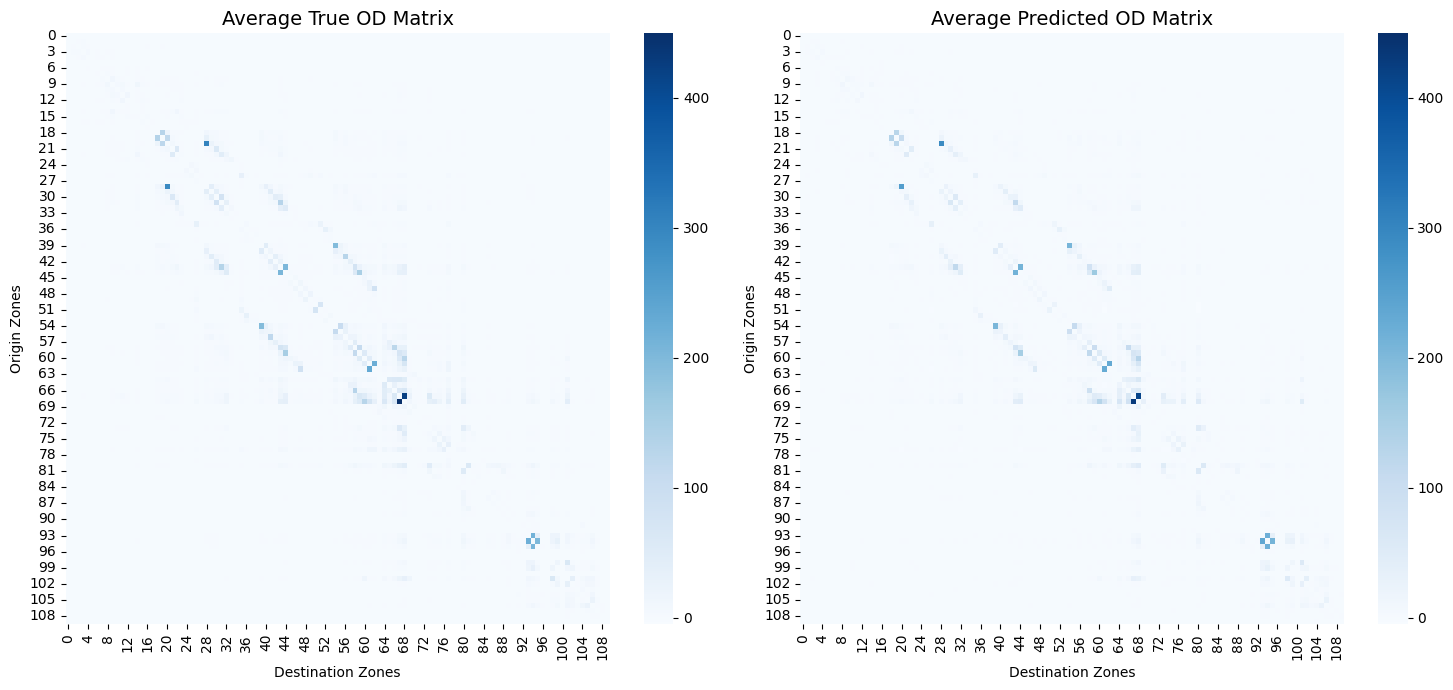

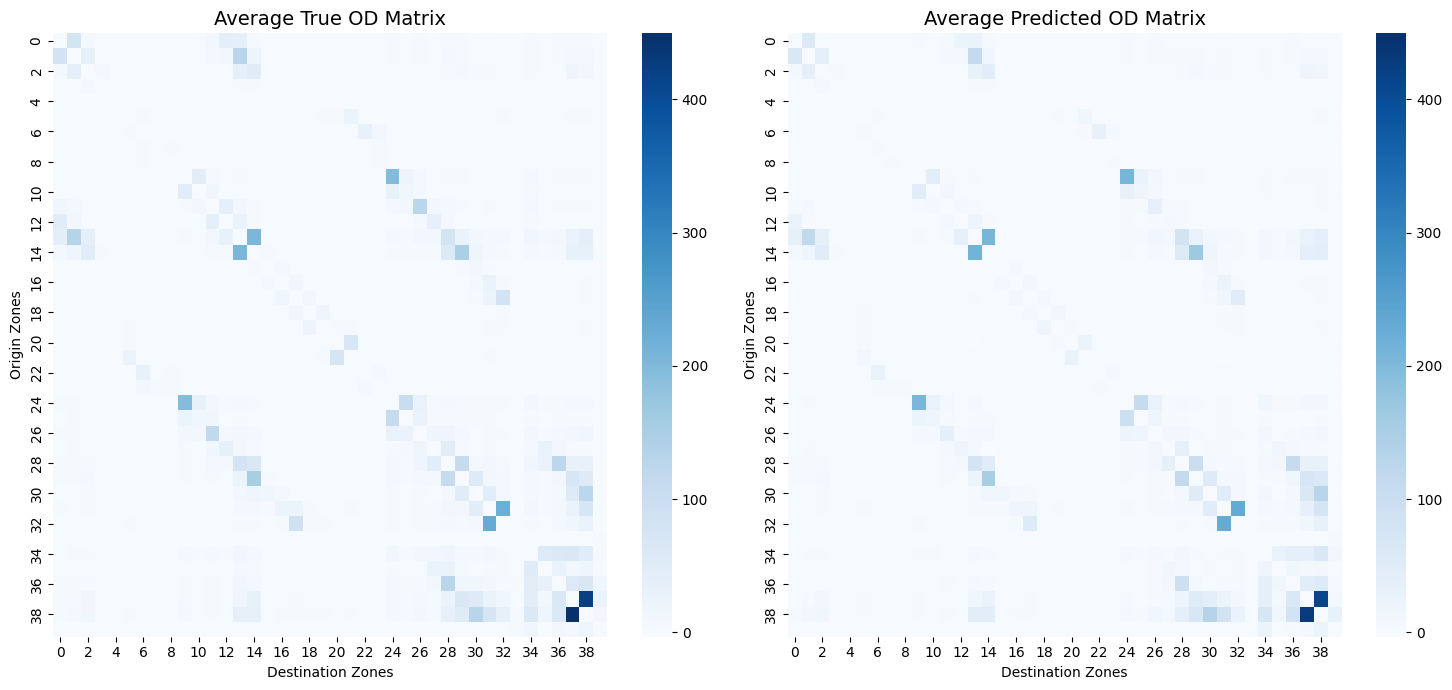

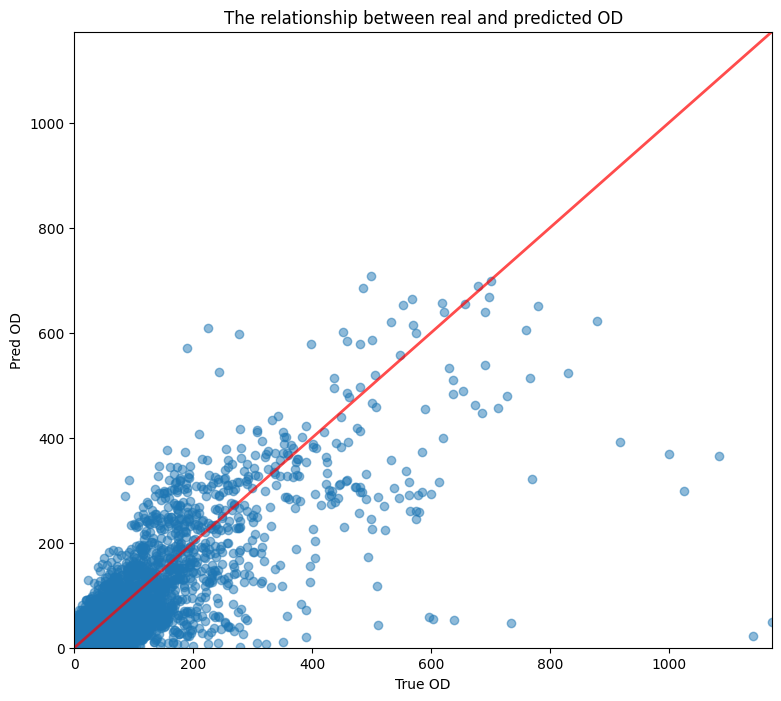

In [7]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import stft
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils.get_X_Freq import get_X_Freq



# 数据准备
def normalize_data(data):
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val), min_val, max_val


class STFTMLP(nn.Module):
    def __init__(self, T, fs=1.0, nperseg=64, noverlap=32, hidden_size=128):
        super(STFTMLP, self).__init__()
        self.T = T
        self.fs = fs
        self.nperseg = nperseg
        self.noverlap = noverlap

        # 计算STFT后的频率和时间点数
        _, _, Zxx_example = stft(np.zeros(T), fs=self.fs, nperseg=self.nperseg, noverlap=self.noverlap)
        n_frequencies, n_times = Zxx_example.shape

        self.mlp = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(n_frequencies * n_times, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, T)
        )

        # He初始化
        for m in self.mlp.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)


    def forward(self, x1, x2):
        N = x1.shape[0]
        amplitudes_diff = []

        for i in range(N):
            # 对每个样本应用STFT
            _, _, Zxx1 = stft(x1[i], fs=self.fs, nperseg=self.nperseg, noverlap=self.noverlap)
            _, _, Zxx2 = stft(x2[i], fs=self.fs, nperseg=self.nperseg, noverlap=self.noverlap)

            # 提取振幅
            amplitude1 = np.abs(Zxx1)
            amplitude2 = np.abs(Zxx2)

            # 计算振幅差值
            diff = amplitude1 - amplitude2
            amplitudes_diff.append(diff)

        # 将差值转换为张量
        amplitudes_diff = np.array(amplitudes_diff)
        amplitudes_diff = torch.tensor(amplitudes_diff, dtype=torch.float32)

        # 通过MLP
        output = self.mlp(amplitudes_diff)  # [N,T]

        output = torch.mean(output, dim=-1)  # [N,]

        return output


# 定义模型
class ODModel(nn.Module):
    def __init__(self, N, temp, freq):
        super(ODModel, self).__init__()

        self.N = N  # 区域数
        self.temp = temp  # 频域差距 [N,]
        self.freq = freq  # 频域差距 [N,]
        n1 = 128  # 隐藏层神经元1
        n2 = 64  # 隐藏层神经元2

        # 权重[α1,α2,α3] --> shape [N, 3]
        self.weights = nn.Parameter(torch.randn(N, 3))

        # MLP层 input [B,N] --> output [B,N*N]
        self.mlp = nn.Sequential(
            nn.Linear(N, n1),
            nn.ReLU(),
            nn.Linear(n1, n2),
            nn.ReLU(),
            nn.Linear(n2, N * N)
        )

    def forward(self, x):
        '''
        前向传播
        :param x: Batch输入Speed --> [B,N]
        :return: Batch输出OD     --> [B,N,N]
        '''
        B,N = x.shape  # [B,N]

        x_temp = np.tile(self.temp, (B, 1))  # [B,N]
        x_freq = np.tile(self.freq, (B, 1))  # [B,N]

        x_random = np.random.normal(loc=0.05, scale=0.01, size=(B, N)).astype(float)  # [B,N]
        x_random = np.clip(x_random, 0, 0.1)

        # print("----------------------------")
        # print(f"速度：{x[0, 66]}\n三个Δ：\n{x_temp[0, 66]}"
        #       f"\n{x_freq[0, 66]}\n{x_random[0, 66]}")




        x_temp_freq_rand = np.stack([x_temp, x_freq, x_random], axis=-1)  # [B,N,3]
        tensor_delta_x = torch.tensor(x_temp_freq_rand,dtype=torch.float).to(x.device)

        # print(f"weight:{self.weights[66]}")

        # 等式计算 Production [B, N] = speed[B,N] + sum([B,N,3] * [1,N,3]) = speed[B,N]+sum([B,N,3]) = [B,N]

        self.weights = self.weights.to(x.device)
        weighted_sum = x + torch.sum(tensor_delta_x * self.weights.unsqueeze(0), dim=2)

        # print(f"预测的production:{weighted_sum[0,66]}")

        # 输入到 MLP 网络中
        od_matrix_flat = self.mlp(weighted_sum)  # [B,N] --> [B, N * N]
        # reshape 最终输出
        od_matrix = od_matrix_flat.view(B, N, N)  # [B, N, N]
        # pro = torch.sum(od_matrix, dim=-1)
        # print(f"production:{pro[0,66]}")

        return od_matrix


# 保存日志文件
# log_filename = f"log/v1_3/training_log_25.1.14版本_{time.strftime('%Y%m%d_%H%M%S')}.log"


#
# with open(log_filename, 'w') as log_file:
#     log_file.write("Epoch, Train Loss, Validation Loss\n")


# 训练过程
def train_model(model, train_loader, val_loader, epochs=100, patience=10, learning_rate=0.001, load=0):
    if load == 1:
        model.load_state_dict(torch.load('ckpt/v1_3/best_model_feature4_25.1.14数据集版本.pth'))
        print(f"best model loaded")

    device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 学习率调度器
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    best_val_loss = float('inf')
    patience_counter = 0
    N = 110

    # 训练过程
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device).float(), targets.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # 计算训练集的平均损失
        train_loss /= len(train_loader)

        # 验证过程
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, targets = data
                inputs, targets = inputs.to(device).float(), targets.to(device).float()

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # 计算验证集的平均损失
        val_loss /= len(val_loader)

        # # 保存每一轮的损失，并打印
        # with open(log_filename, 'a') as log_file:
        #     log_file.write(f"{epoch + 1}, {train_loss:.4f}, {val_loss:.4f}\n")

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        # ({optimizer.param_groups[0]['lr']:.6f})

        # 提前停止机制
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # 保存最佳模型
            torch.save(model.state_dict(), "ckpt/v1_3/best_model_feature4_25.1.14数据集版本.pth")
            print(f"best saved at epoch{epoch + 1},best：{best_val_loss:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


    return best_val_loss

def calculate_rmse_mae(predictions, targets):
    mse = torch.mean((predictions - targets) ** 2)
    rmse = torch.sqrt(mse)
    mae = torch.mean(torch.abs(predictions - targets))

    # 计算 MAPE，避免除以零
    non_zero_mask = targets != 0
    if non_zero_mask.sum() > 0:
        mape = torch.mean(
            torch.abs((predictions[non_zero_mask] - targets[non_zero_mask]) / targets[non_zero_mask]))
    else:
        mape = torch.tensor(0.0)
    return rmse.item(), mae.item(), mape.item()


def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 设置所有GPU的随机种子


# 加载数据
def load_data(is_mcm=False):

    log_filename = f"log/v1_3/A完整批处理的调参_MCM_{is_mcm}.log"
    set_seed(42)

    # 加载数据
    # data = np.load('data/武汉速度数据集_1KM_110区域_25.1.14.npy')  # 形状 [T, N, 2]
    # speed = data[:, :, 0]  # 平均速度 [T, N]
    #
    # od = np.load('data/武汉OD数据集_1KM_110区域_过滤cnt_对角线0_25.1.14.npy')  # 形状 [T, N, N]
    if is_mcm:
        speed = np.load('data/Speed_完整批处理_3.17_Final_MCM_60.npy')
        od = np.load('data/OD_完整批处理_3.17_Final_MCM_60.npy')

        # 获取数据长度 T
        T, N = speed.shape

        train_size = int(T * 0.9537)
        val_size = int(T * 0.0225)

    else:
        speed = np.load('data/Speed_完整批处理_3.17_Final.npy')
        od = np.load('data/OD_完整批处理_3.17_Final.npy')

        # 获取数据长度 T
        T, N = speed.shape

        # 按顺序划分数据
        train_size = int(T * 0.6)
        val_size = int(T * 0.2)

    # 顺序划分索引
    train_indices = np.arange(0, train_size)
    val_indices = np.arange(train_size, train_size + val_size)
    test_indices = np.arange(train_size + val_size, T)

    # 按索引划分数据
    speed_train, speed_val, speed_test = speed[train_indices], speed[val_indices], speed[test_indices]
    od_train, od_val, od_test = od[train_indices], od[val_indices], od[test_indices]
    # x_random_train, x_random_val, x_random_test = x_random[train_indices], x_random[val_indices], x_random[test_indices]

    # 输出划分后的数据形状
    print("6:2:2顺序划分的训练集Speed", speed_train.shape, "OD", od_train.shape)
    print("6:2:2顺序划分的验证集Speed", speed_val.shape, "OD", od_val.shape)
    print("6:2:2顺序划分的测试集Speed", speed_test.shape, "OD", od_test.shape)

    # 在训练集上计算 OD 出发总量
    od_train_departures = np.sum(od_train, axis=-1)  # 形状 [T_train, N]



    # 计算每个区域在 T_train 时间步的平均速度和平均出发总量
    mean_speed = np.mean(speed_train, axis=0)  # 每个区域的平均速度 [N,]
    mean_departures = np.mean(od_train_departures, axis=0)  # 每个区域的平均出发总量 [N,]
    # 计算平均速度和平均出发总量的差值
    temporal = (mean_departures - mean_speed).astype(float)  # [N,]


    # 频域差距求解
    seq1 = torch.tensor(speed_train, dtype=torch.float32).transpose(0, 1)  # [N,T]
    seq2 = torch.tensor(od_train_departures, dtype=torch.float32).transpose(0, 1) # [N,T]
    stftmlp = STFTMLP(train_size)
    freq = stftmlp(seq1, seq2)



    # 归一化
    scaler = MinMaxScaler()
    # print(f"test_data: {speed_test[-2, 10:20]}")
    train_data = scaler.fit_transform(speed_train.reshape(-1, 1)).reshape(speed_train.shape)
    val_data = scaler.transform(speed_val.reshape(-1, 1)).reshape(speed_val.shape)
    test_data = scaler.transform(speed_test.reshape(-1, 1)).reshape(speed_test.shape)

    # print(f"train_data: {train_data[:10, 66]}")

    # print(f"test_data: {test_data[-2, 10:20]}")

    train_data = torch.tensor(train_data, dtype=torch.float32)
    val_data = torch.tensor(val_data, dtype=torch.float32)
    test_data = torch.tensor(test_data, dtype=torch.float32)

    train_target = torch.tensor(od_train, dtype=torch.float32)
    val_target = torch.tensor(od_val, dtype=torch.float32)
    test_target = torch.tensor(od_test, dtype=torch.float32)

    # 打印结果形状
    print("归一化后的训练集 shape:", train_data.shape, "OD形状", train_target.shape)
    print("归一化后的验证集 shape:", val_data.shape, "OD形状", val_target.shape)
    print("归一化后的测试集 shape:", test_data.shape, "OD形状", test_target.shape)

    train_dataset = TensorDataset(train_data, train_target)
    val_dataset = TensorDataset(val_data, val_target)
    test_dataset = TensorDataset(test_data, test_target)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    scaler = MinMaxScaler()
    x_temp = scaler.fit_transform(temporal.reshape(-1, 1))

    scaler = MinMaxScaler()
    x_freq = scaler.fit_transform(freq.detach().numpy().reshape(-1, 1))

    x_temp = np.squeeze(x_temp, axis=-1)
    x_freq = np.squeeze(x_freq, axis=-1)

    return train_loader, val_loader, test_loader, x_temp, x_freq,log_filename


# 测试
def test_model(model, test_loader, lr: float,log_name=None):
    device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.load_state_dict(torch.load("ckpt/v1_3/best_model_feature4_25.1.14数据集版本.pth"))

    # 打印结构
    # summary(model, input_size=(32, 110, 4))

    model.eval()
    test_loss = 0
    rmse_total = 0
    mae_total = 0
    mape_total = 0
    criterion = nn.MSELoss()
    N = 110

    all_real_od = []
    all_pred_od = []

    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            # 设置对角线掩码
            mask = torch.ones_like(targets)
            for i in range(N):
                mask[:, i, i] = 0  # 对角线上的元素设为 0

            print(f"输入:{inputs.shape},标签:{targets.shape}")

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # 计算 RMSE 和 MAE
            rmse, mae, mape = calculate_rmse_mae(outputs * mask, targets)
            rmse_total += rmse
            mae_total += mae
            mape_total += mape

            all_real_od.append(targets.cpu().numpy())
            all_pred_od.append(outputs.cpu().numpy())

    test_loss /= len(test_loader)
    rmse_total /= len(test_loader)
    mae_total /= len(test_loader)
    mape_total /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test RMSE: {rmse_total:.4f} Test MAE: {mae_total:.4f} Test MAPE: {mape_total:.4f}")

    torch.save(model.state_dict(),
               f"ckpt/v1_3/best_model_feature4_25.1.14数据集版本_{test_loss:.4f}_{rmse_total:.4f}_{mae_total:.4f}_lr_{lr}.pth")

    # 计算平均的OD矩阵
    # 设置不使用科学计数法
    np.set_printoptions(precision=2, suppress=True)
    all_real_od_t = np.concatenate(all_real_od, axis=0)
    all_pred_od_t = np.concatenate(all_pred_od, axis=0)
    all_real_od = np.mean(all_real_od_t, axis=0)
    all_pred_od = np.mean(all_pred_od_t, axis=0)

    print("-------------------不同时间步上---------------------")
    for i in range(0, all_real_od_t.shape[0]):
        maxi = all_real_od_t[i].max()
        mini = all_real_od_t[i].min()
        maxi_pred = all_pred_od_t[i].max()
        mini_pred = all_pred_od_t[i].min()
        print(f"-----真实值 step{i} {maxi:.2f} {mini:.2f}------")
        print(np.round(all_real_od_t[i, 60:68, 60:68].astype(np.float32)))  # 保留小数点后1位
        print(f"-----预测值 step{i} {maxi_pred:.2f} {mini_pred:.2f}------")
        print(np.round(all_pred_od_t[i, 60:68, 60:68].astype(np.float32)))  # 保留小数点后1位

    print("-------------------平均时间步上---------------------")
    print(np.round(all_real_od[60:68, 60:68].astype(np.float32), 0).astype(int))  # 保留小数点后1位
    print("----------------------------------------------------")
    print(np.round(all_pred_od[60:68, 60:68].astype(np.float32), 0).astype(int))  # 保留小数点后1位

    vmin = min(all_pred_od.min(), all_real_od.min())
    vmax = max(all_pred_od.max(), all_real_od.max())

    true_max = all_real_od_t.max()
    pred_max = all_pred_od_t.max()
    print(f"真实最大值{true_max},预测最大值，{pred_max}")

    np.save("./可视化/测试集TNN/Pred_ours.npy",all_pred_od_t)
    np.save("./可视化/测试集TNN/真实值.npy",all_real_od_t)
    
    colors = "Blues"  # Blues YlGn Greens YlGnBu


    plt.figure(figsize=(15, 7))

    # 绘制真实 OD 热力图
    plt.subplot(1, 2, 1)
    sns.heatmap(all_real_od, cmap=colors, cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average True OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 绘制预测 OD 热力图
    plt.subplot(1, 2, 2)
    sns.heatmap(all_pred_od, cmap=colors, cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average Predicted OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 调整布局并显示
    plt.tight_layout()
    # plt.show()
    plt.savefig("ODE1.3_1.png")


    start_id = 30  # 35
    end_id = 70  # 68
    vmin = min(all_pred_od[start_id:end_id, start_id:end_id].min(), all_real_od[start_id:end_id, start_id:end_id].min())
    vmax = max(all_pred_od[start_id:end_id, start_id:end_id].max(), all_real_od[start_id:end_id, start_id:end_id].max())

    plt.figure(figsize=(15, 7))
    # 绘制真实 OD 热力图
    plt.subplot(1, 2, 1)
    sns.heatmap(all_real_od[start_id:end_id, start_id:end_id], cmap=colors, cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average True OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 绘制预测 OD 热力图
    plt.subplot(1, 2, 2)
    sns.heatmap(all_pred_od[start_id:end_id, start_id:end_id], cmap=colors, cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average Predicted OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

   #  调整布局并显示
    plt.tight_layout()
    plt.savefig("ODE1.3_2.png")
    # plt.show()



    # 绘制散点图
    all_real_od_flat = all_real_od_t.flatten()
    all_pred_od_flat = all_pred_od_t.flatten()

    plt.figure(figsize=(9, 8))
    plt.scatter(all_real_od_flat, all_pred_od_flat, alpha=0.5)

    # 设置坐标轴范围从 0 开始
    max_val = np.max([np.max(all_real_od_flat), np.max(all_pred_od_flat)])
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)

    # 绘制对角线
    lims = [0, max_val]
    plt.plot(lims, lims, color='red', linewidth=2, linestyle='-', alpha=0.7)

    plt.xlabel('True OD')
    plt.ylabel('Pred OD')
    plt.title('The relationship between real and predicted OD')
    plt.savefig('ODE1.3_3.png')
    # plt.show()





    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test RMSE: {rmse_total:.4f} Test MAE: {mae_total:.4f} Test MAPE: {mape_total:.4f}")
    print(f"Device:{device}")
    with open(log_name, 'a') as log_file:
        log_file.write(f"Lr = {lr},Test Loss: {test_loss:.4f} RMSE: {rmse_total:.4f} MAE: {mae_total:.4f} MAPE: {mape_total:.4f}\n")


# 主程序
def main():



    # 定义学习率列表
    # lr_list = [0.1, 0.05, 0.045, 0.04, 0.035, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005,
    #            0.0045, 0.004, 0.0035, 0.003, 0.0025, 0.002, 0.0015, 0.001,
    #            0.0008, 0.0005, 0.0004, 0.0003, 0.0002, 0.0001]
    lr_list = [0.03]  # 20 0.03
    lr_list = [0.02]  # 30 0.02


    # 遍历学习率列表
    for lr in lr_list:
        print(f"当前学习率: {lr}")

        train_loader, val_loader, test_loader, temp, freq, log_filename = load_data(True)

        model = ODModel(N=110, temp=temp, freq=freq)  # N为区域数

        # 训练模型
        train_model(model, train_loader, val_loader, epochs=500, patience=30, learning_rate=lr, load=0)

        # 测试模型
        test_model(model, test_loader, lr=lr,log_name=log_filename)


if __name__ == "__main__":
    main()


## 绘图

真实最大值1173.0, 预测最大值列表：[569.8534, 708.4861]


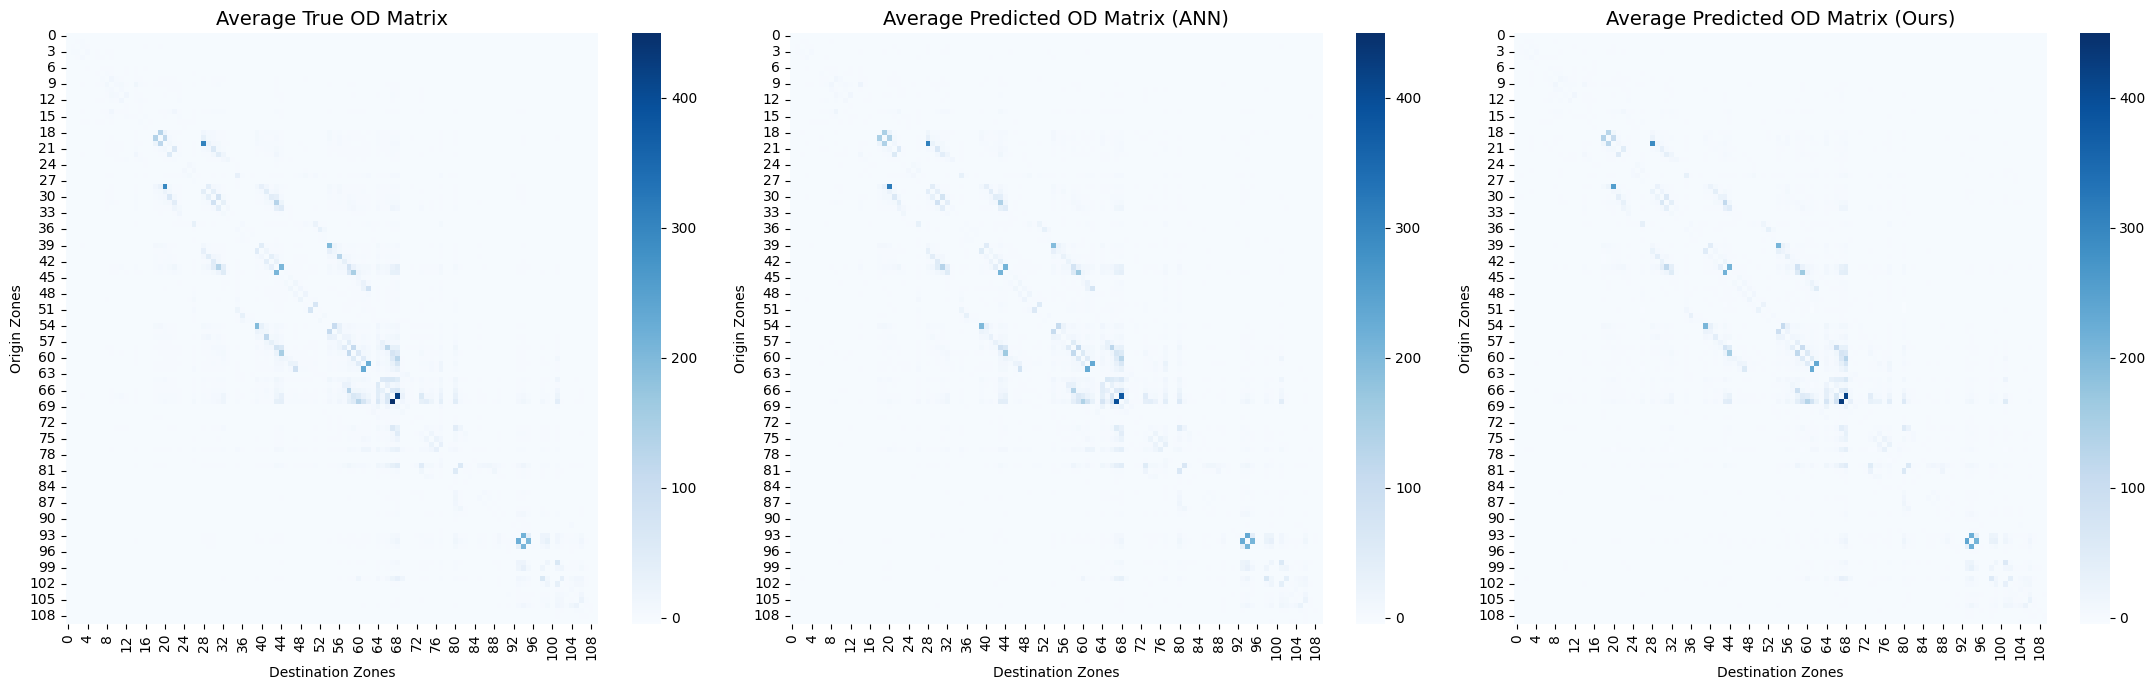

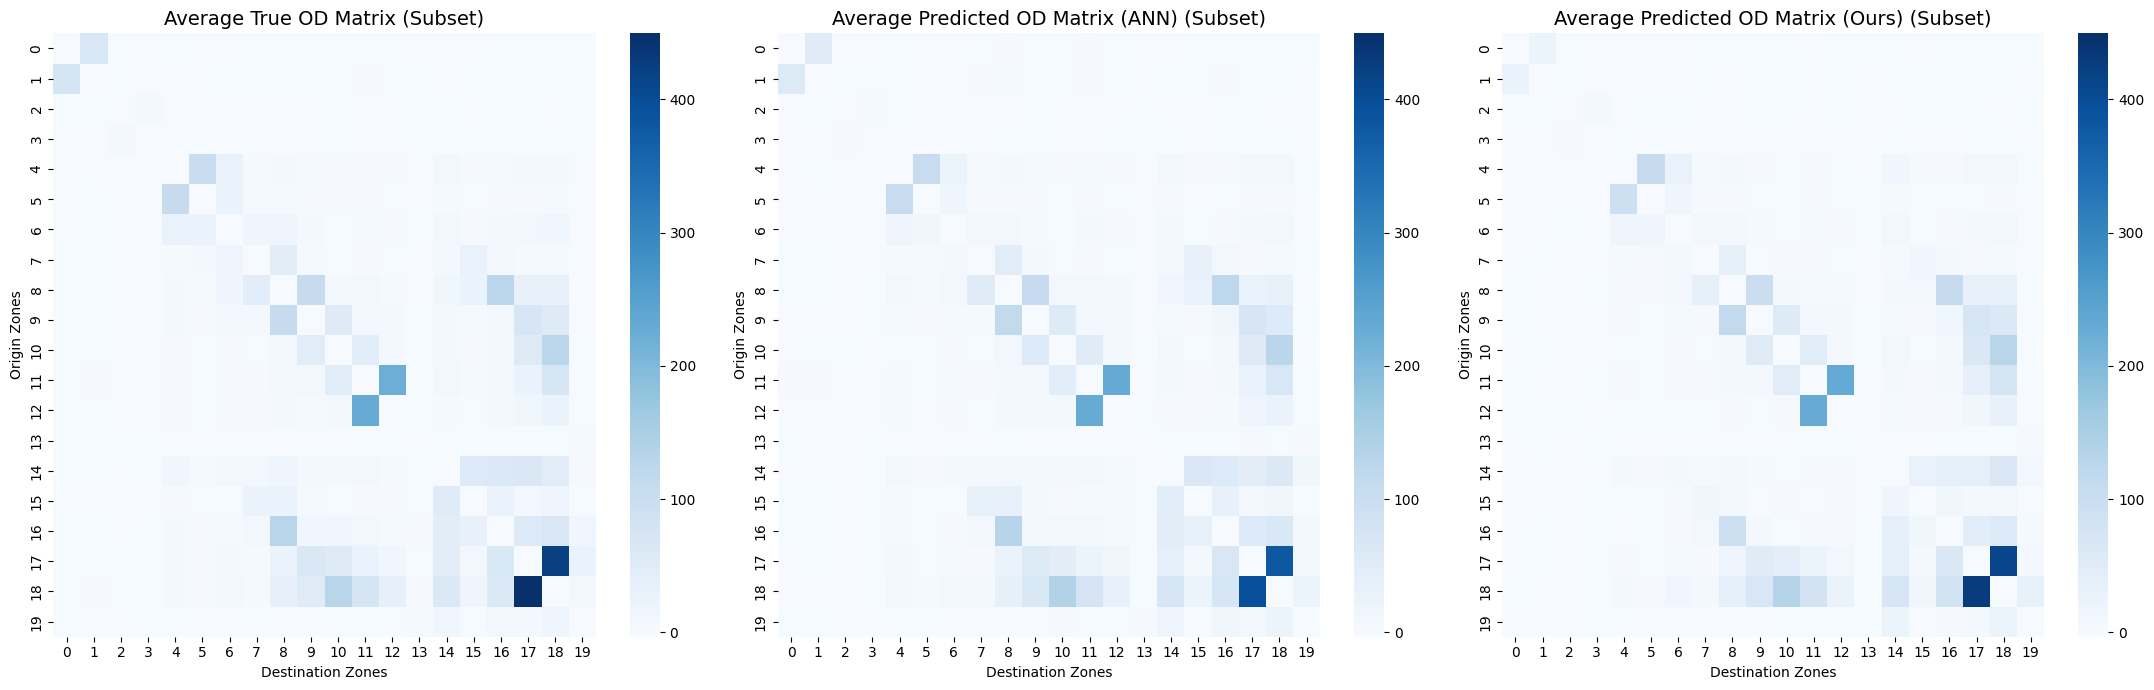

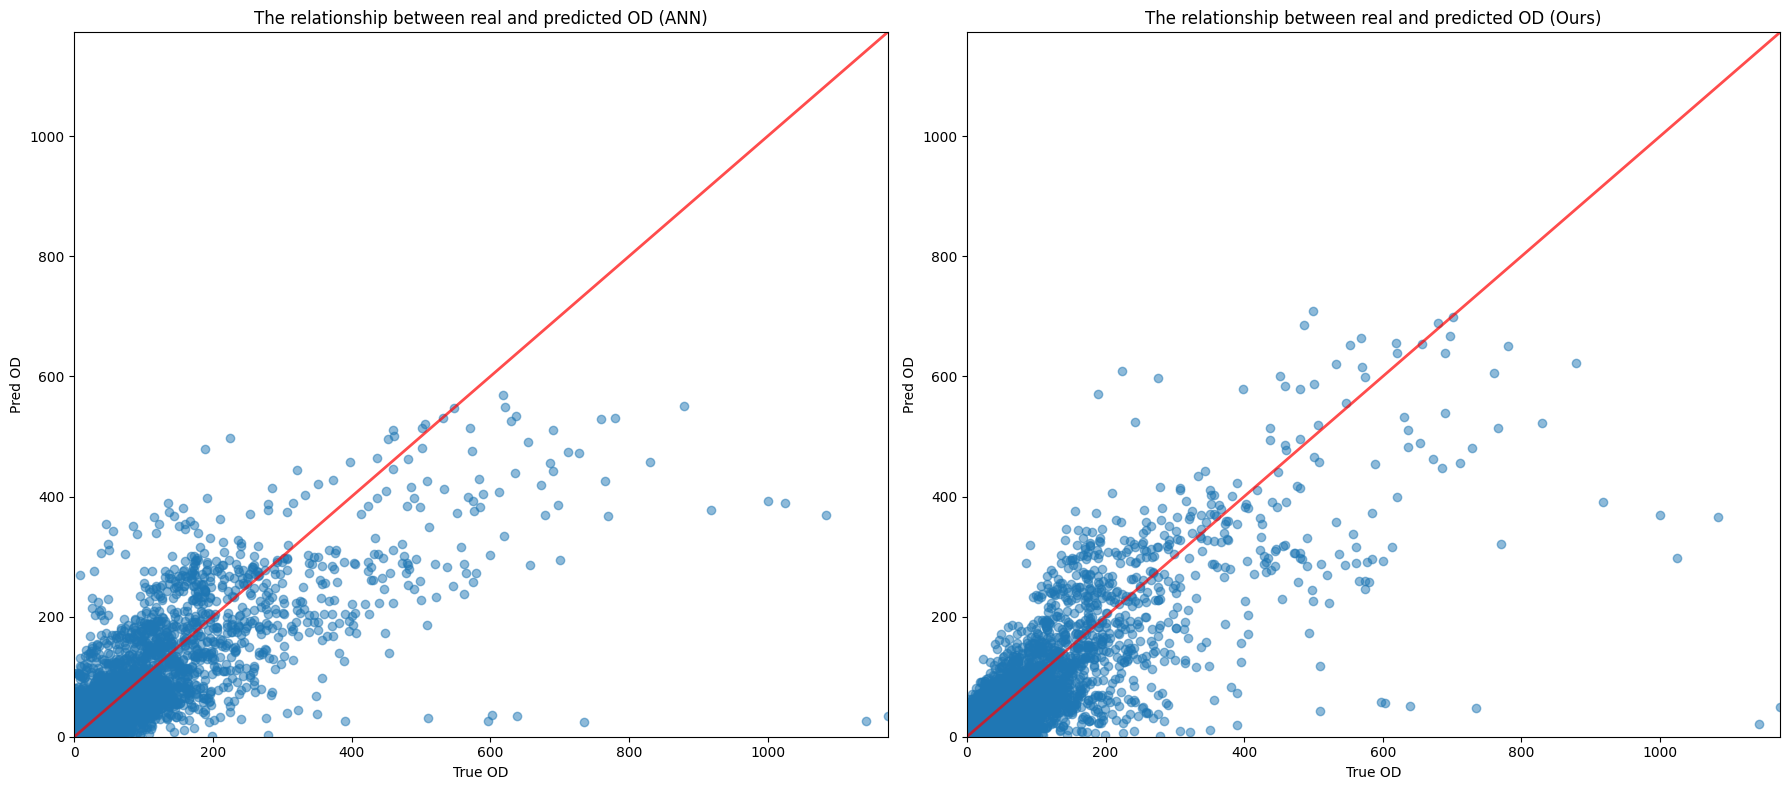

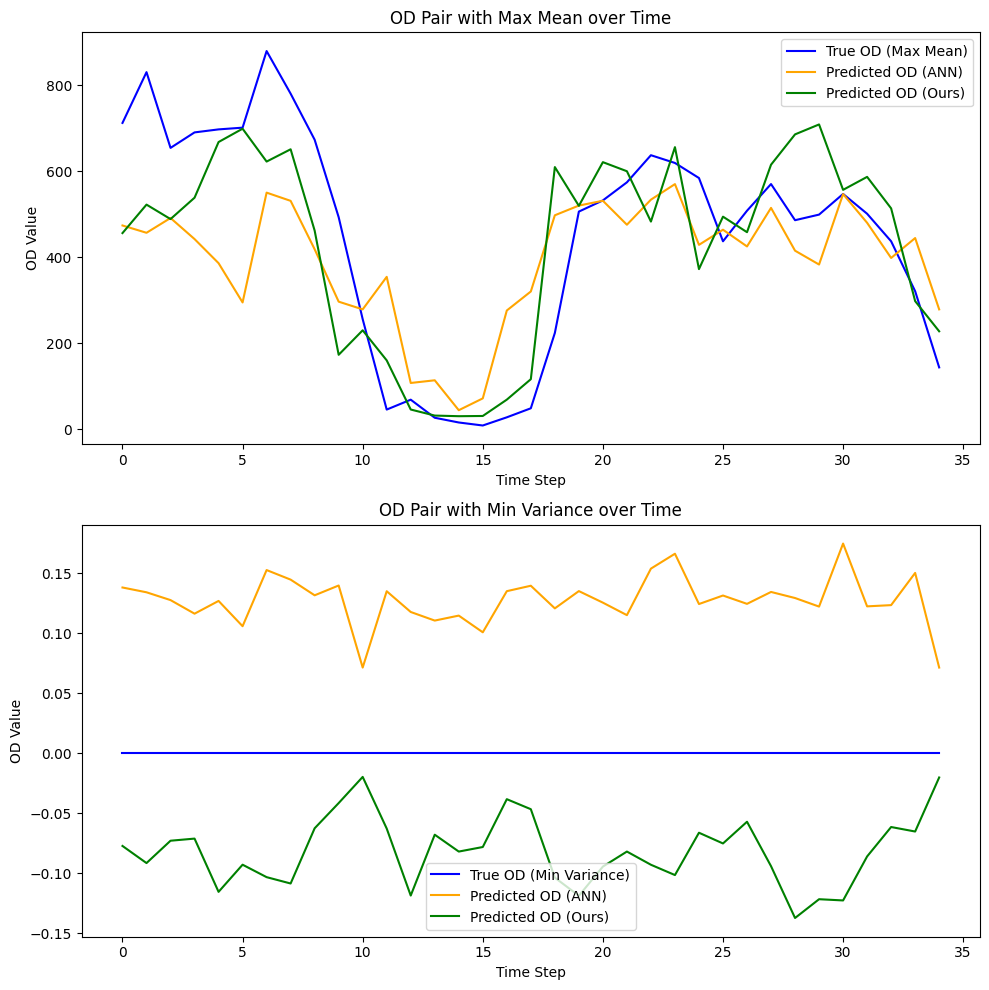

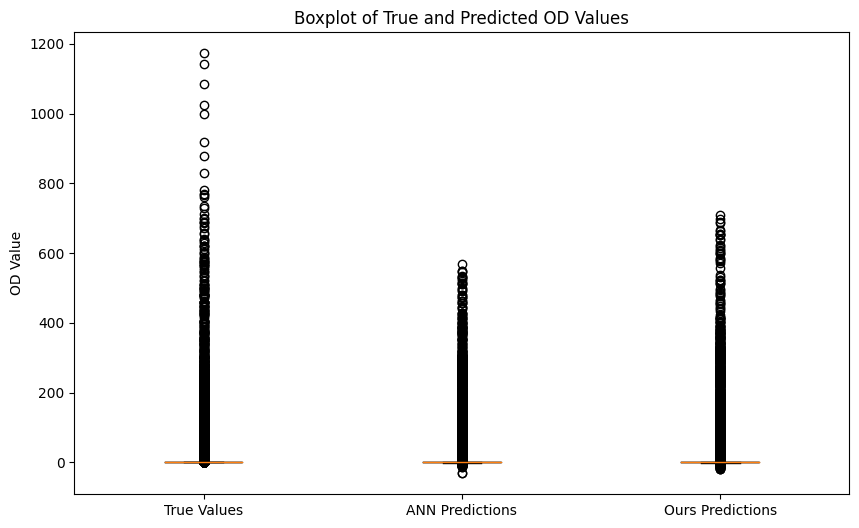

<Figure size 640x480 with 0 Axes>

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def load_data():
    try:
        pred_ann = np.load('./可视化/测试集TNN/Pred_ANN.npy')
        pred_ours = np.load('./可视化/测试集TNN/Pred_ours.npy')
        real_values = np.load('./可视化/测试集TNN/真实值.npy')
        return pred_ann, pred_ours, real_values
    except FileNotFoundError:
        print("数据文件未找到，请检查文件路径和文件名。")
        return None, None, None


def plot_heatmaps(all_pred_od_t_list, all_real_od_t):
    all_real_od = np.mean(all_real_od_t, axis=0)
    all_pred_od_list = [np.mean(pred_od_t, axis=0) for pred_od_t in all_pred_od_t_list]

    vmin = min([pred_od.min() for pred_od in all_pred_od_list] + [all_real_od.min()])
    vmax = max([pred_od.max() for pred_od in all_pred_od_list] + [all_real_od.max()])

    true_max = all_real_od_t.max()
    pred_max_list = [pred_od_t.max() for pred_od_t in all_pred_od_t_list]
    print(f"真实最大值{true_max}, 预测最大值列表：{pred_max_list}")

    colors = "Blues"
    num_preds = len(all_pred_od_list)
    fig, axes = plt.subplots(1, num_preds + 1, figsize=(15 * (num_preds + 1) // 2, 7))

    # 绘制真实 OD 热力图
    sns.heatmap(all_real_od, cmap=colors, cbar=True, vmin=vmin, vmax=vmax, ax=axes[0])
    axes[0].set_title("Average True OD Matrix", fontsize=14)
    axes[0].set_xlabel("Destination Zones")
    axes[0].set_ylabel("Origin Zones")

    # 绘制预测 OD 热力图
    method_names = ["ANN", "Ours"]
    for i, pred_od in enumerate(all_pred_od_list):
        sns.heatmap(pred_od, cmap=colors, cbar=True, vmin=vmin, vmax=vmax, ax=axes[i + 1])
        axes[i + 1].set_title(f"Average Predicted OD Matrix ({method_names[i]})", fontsize=14)
        axes[i + 1].set_xlabel("Destination Zones")
        axes[i + 1].set_ylabel("Origin Zones")

    plt.tight_layout()
    plt.savefig("ODE1.3_1.png")


def plot_heatmaps_subset(all_pred_od_t_list, all_real_od_t):
    colors = "Blues"
    all_real_od = np.mean(all_real_od_t, axis=0)
    all_pred_od_list = [np.mean(pred_od_t, axis=0) for pred_od_t in all_pred_od_t_list]

    start_id = 50
    end_id = 70
    vmin = min([pred_od[start_id:end_id, start_id:end_id].min() for pred_od in all_pred_od_list] +
               [all_real_od[start_id:end_id, start_id:end_id].min()])
    vmax = max([pred_od[start_id:end_id, start_id:end_id].max() for pred_od in all_pred_od_list] +
               [all_real_od[start_id:end_id, start_id:end_id].max()])

    num_preds = len(all_pred_od_list)
    fig, axes = plt.subplots(1, num_preds + 1, figsize=(15 * (num_preds + 1) // 2, 7))

    # 绘制真实 OD 热力图
    sns.heatmap(all_real_od[start_id:end_id, start_id:end_id], cmap=colors, cbar=True, vmin=vmin, vmax=vmax,
                ax=axes[0])
    axes[0].set_title("Average True OD Matrix (Subset)", fontsize=14)
    axes[0].set_xlabel("Destination Zones")
    axes[0].set_ylabel("Origin Zones")

    # 绘制预测 OD 热力图
    method_names = ["ANN", "Ours"]
    for i, pred_od in enumerate(all_pred_od_list):
        sns.heatmap(pred_od[start_id:end_id, start_id:end_id], cmap=colors, cbar=True, vmin=vmin, vmax=vmax,
                    ax=axes[i + 1])
        axes[i + 1].set_title(f"Average Predicted OD Matrix ({method_names[i]}) (Subset)", fontsize=14)
        axes[i + 1].set_xlabel("Destination Zones")
        axes[i + 1].set_ylabel("Origin Zones")

    plt.tight_layout()
    plt.savefig("ODE1.3_2.png")


def plot_scatter(all_pred_od_t_list, all_real_od_t):
    all_real_od_flat = all_real_od_t.flatten()
    all_pred_od_flat_list = [pred_od_t.flatten() for pred_od_t in all_pred_od_t_list]

    max_val = np.max([np.max(all_real_od_flat)] + [np.max(pred_od_flat) for pred_od_flat in all_pred_od_flat_list])
    lims = [0, max_val]

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    method_names = ["ANN", "Ours"]
    for i, pred_od_flat in enumerate(all_pred_od_flat_list):
        axes[i].scatter(all_real_od_flat, pred_od_flat, alpha=0.5)
        axes[i].set_xlim(0, max_val)
        axes[i].set_ylim(0, max_val)
        axes[i].plot(lims, lims, color='red', linewidth=2, linestyle='-', alpha=0.7)
        axes[i].set_xlabel('True OD')
        axes[i].set_ylabel('Pred OD')
        axes[i].set_title(f'The relationship between real and predicted OD ({method_names[i]})')

    plt.tight_layout()
    plt.savefig('ODE1.3_3.png')


def plot_od_time_series(all_pred_od_t_list, all_real_od_t):
    T, N, _ = all_real_od_t.shape
    real_od_means = all_real_od_t.mean(axis=0).flatten()
    real_od_variances = all_real_od_t.var(axis=0).flatten()

    # 找到具有最大均值和最小方差的 OD 对索引
    max_mean_index = np.argmax(real_od_means)
    min_var_index = np.argmin(real_od_variances)

    # 还原为二维索引
    max_mean_row, max_mean_col = np.unravel_index(max_mean_index, (N, N))
    min_var_row, min_var_col = np.unravel_index(min_var_index, (N, N))

    # 获取真实值和预测值序列
    real_a1 = all_real_od_t[:, max_mean_row, max_mean_col]
    real_a2 = all_real_od_t[:, min_var_row, min_var_col]
    pred_ann_a1 = all_pred_od_t_list[0][:, max_mean_row, max_mean_col]
    pred_ann_a2 = all_pred_od_t_list[0][:, min_var_row, min_var_col]
    pred_ours_a1 = all_pred_od_t_list[1][:, max_mean_row, max_mean_col]
    pred_ours_a2 = all_pred_od_t_list[1][:, min_var_row, min_var_col]

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # 绘制具有最大均值的 OD 对时间序列
    axes[0].plot(real_a1, label='True OD (Max Mean)', color='blue')
    axes[0].plot(pred_ann_a1, label='Predicted OD (ANN)', color='orange')
    axes[0].plot(pred_ours_a1, label='Predicted OD (Ours)', color='green')
    axes[0].set_title('OD Pair with Max Mean over Time')
    axes[0].set_xlabel('Time Step')
    axes[0].set_ylabel('OD Value')
    axes[0].legend()

    # 绘制具有最小方差的 OD 对时间序列
    axes[1].plot(real_a2, label='True OD (Min Variance)', color='blue')
    axes[1].plot(pred_ann_a2, label='Predicted OD (ANN)', color='orange')
    axes[1].plot(pred_ours_a2, label='Predicted OD (Ours)', color='green')
    axes[1].set_title('OD Pair with Min Variance over Time')
    axes[1].set_xlabel('Time Step')
    axes[1].set_ylabel('OD Value')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('ODE1.3_4.png')

def plot_boxplot(all_pred_od_t_list, all_real_od_t):
    real_values_flat = all_real_od_t.flatten()
    pred_ann_flat = all_pred_od_t_list[0].flatten()
    pred_ours_flat = all_pred_od_t_list[1].flatten()

    data = [real_values_flat, pred_ann_flat, pred_ours_flat]
    labels = ['True Values', 'ANN Predictions', 'Ours Predictions']

    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=labels)
    plt.title('Boxplot of True and Predicted OD Values')
    plt.ylabel('OD Value')
    plt.show()
    plt.savefig('ODE1.3_5.png')


if __name__ == "__main__":
    pred_ann, pred_ours, real_values = load_data()
    if pred_ann is not None and pred_ours is not None and real_values is not None:
        all_pred_od_t_list = [pred_ann, pred_ours]
        plot_heatmaps(all_pred_od_t_list, real_values)
        plot_heatmaps_subset(all_pred_od_t_list, real_values)
        plot_scatter(all_pred_od_t_list, real_values)
        plot_od_time_series(all_pred_od_t_list, real_values)
        plot_boxplot(all_pred_od_t_list, real_values)
    